# 1. Khai báo các thư viện cần thiết
Ta sẽ sử dụng các thư viện được khai báo để hỗ trợ cho việc tính toán, xử lí dữ liệu, huấn luyện mô hình, xử lý hình ảnh

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch.nn as nn
import math
from tqdm import tqdm
from keras.datasets.mnist import load_data
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Resize

ModuleNotFoundError: No module named 'matplotlib'

# 2. Xử lý dữ liệu
Ta sẽ huấn luyện mô hình trên tập dữ liệu MNIST (được tích hợp sẵn trong thư viện keras). Trước khi huấn luyện, ta cần tải dữ liệu từ thư viện và xử lý dữ liệu (normalization, chỉnh kích thước ảnh,..)

In [ ]:
(trainX, trainy), (testX, testy) = load_data()

# Chuẩn hóa giá trị sao cho giá trị về khoảng [0, 1]
trainX = np.float32(trainX) / 255.
testX = np.float32(testX) / 255.

resize_transform = Resize((32, 32)) # Điều chỉnh kích thước ảnh sao cho phù hợp với kích thước đầu vào của U-Net
train_dataset = TensorDataset(resize_transform(torch.from_numpy(trainX).unsqueeze(1)))

# 3. Xây dựng mô hình
Từ thuật toán được mô tả từ bài báo, ta có thể cài đặt các hàm khuếch tán thuận, lấy mẫu, huấn luyện mô hình.

In [ ]:
class DiffusionModel:
  def __init__(self, T: int, model: nn.Module, device: str):
    self.T = T
    self.function_approximator = model.to(device) # Khai báo mô hình dự đoán hàm xấp xĩ
    self.device = device

    self.beta = torch.linspace(1e-4, 0.02, T).to(device) # Khai báo lập trình phương sai
    self.alpha = 1. - self.beta
    self.alpha_bar = torch.cumprod(self.alpha, dim=0)

  def forward_process(self, x0, t): # Quá trình khuếch tán thuận
    alpha_bar_t = self.alpha_bar[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) # Việc unsqueeze thế này là để thêm một chiều vào Tensor, giúp đồng bộ chiều dữ liệu cho phù hợp với các phép tính toán
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1. - alpha_bar_t)
    eps = torch.randn_like(x0)
    return sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * eps, eps

  def training_step(self, x0, optimizer): # Các bước trong một lần huấn luyện batch
    batch_size = x0.shape[0] # Số mẫu trong 1 batch
    t = torch.randint(0, self.T, (batch_size,), device = self.device) # Chọn ngẫu nhiên T
    eps = torch.randn_like(x0) # Lấy mẫu eps sao cho shape như x0
    xt, eps = self.forward_process(x0, t)
    predicted_eps = self.function_approximator(xt, t)
    loss = F.mse_loss(predicted_eps, eps)
    optimizer.zero_grad() # Xóa hết gradients từ bước trước để tránh việc cộng dồn gradient
    loss.backward() # Thực hiện cập nhập tham số
    optimizer.step() # Tối ưu siêu tham số
    return loss.item()

  def train(self, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5) # Sử dụng thuật toán tối ưu Adam để tối ưu siêu tham số
    for epoch in range(num_epochs):
      # Với mỗi epoch, ta duyệt qua từng batch và thực hiện bước huấn luyện
      total_loss = 0
      for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        x0 = batch[0].to(device) # Chuyển sang thiết bị thích hợp nhằm giảm tốc độ tính toán (khi sử dụng GPU)
        total_loss += self.training_step(x0, optimizer)
      print(f"Average Loss = {total_loss / len(dataloader)}")

  @torch.no_grad() # Vì ta không cần gradient trong bước sampling nên ta sẽ vô hiệu hóa việc tính gradient, giúp tiết kiệm tài nguyên và thời gian chạy
  def sampling(self, n_samples=1, image_channels=1, img_size=(32, 32)): # Số mẫu, số kênh ảnh, kích thước ảnh
    x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]), device=self.device) # Lấy mẫu ban đầu
    # Bắt đầu thực hiện các bước trong thuật toán sampling
    for t in tqdm(range(self.T-1, -1, -1)):
      z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
      t = torch.ones(n_samples, dtype=torch.long, device=self.device) * t
      alpha_t = self.alpha[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
      alpha_bar_t = self.alpha_bar[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
      sqrt_alpha_t = torch.sqrt(alpha_t)
      beta_t = self.beta[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
      sqrt_one_minus_alpha_bar_t = torch.sqrt(1. - alpha_bar_t)
      mean = 1 / sqrt_alpha_t * (x - (1 - alpha_t) / sqrt_one_minus_alpha_bar_t * self.function_approximator(x, t))
      sigma = torch.sqrt(beta_t)
      x = mean + sigma * z
    return x

  @torch.no_grad()
  def sampling_timelapse(self, n_samples=10, image_channels=1, img_size=(32, 32), interval=100):
      x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]), device=self.device)
      timelapse_images = []

      for t in tqdm(range(self.T - 1, -1, -1)):
          z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
          t_tensor = torch.ones(n_samples, dtype=torch.long, device=self.device) * t
          alpha_t = self.alpha[t_tensor].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
          alpha_bar_t = self.alpha_bar[t_tensor].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
          sqrt_alpha_t = torch.sqrt(alpha_t)
          beta_t = self.beta[t_tensor].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
          sqrt_one_minus_alpha_bar_t = torch.sqrt(1. - alpha_bar_t)
          mean = 1 / sqrt_alpha_t * (x - (1 - alpha_t) / sqrt_one_minus_alpha_bar_t * self.function_approximator(x, t_tensor))
          sigma = torch.sqrt(beta_t)
          x = mean + sigma * z

          if t % interval == 0 or t == self.T - 1: # Capture image at interval or at the beginning
              timelapse_images.append(x.cpu())

      return timelapse_images

Để học từ dữ liệu, mô hình được chọn để học các tham số là U-Net, mã nguồn cài đặt U-Net được tham khảo từ [Maxime Vandegar](https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/blob/main/Denoising_Diffusion_Implicit_Models/unet.py).

In [ ]:
def get_timestep_embedding(timesteps, embedding_dim: int):
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.type(torch.float32)[:, None] * emb[None, :]
    emb = torch.concat([torch.sin(emb), torch.cos(emb)], axis=1)

    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))

    assert emb.shape == (timesteps.shape[0], embedding_dim), f"{emb.shape}"
    return emb


class Downsample(nn.Module):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=2, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.conv(x)
        assert x.shape == (B, C, H // 2, W // 2)
        return x


class Upsample(nn.Module):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=1, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape

        x = nn.functional.interpolate(x, size=None, scale_factor=2, mode='nearest')

        x = self.conv(x)
        assert x.shape == (B, C, H * 2, W * 2)
        return x


class Nin(nn.Module):

    def __init__(self, in_dim, out_dim, scale=1e-10):
        super(Nin, self).__init__()

        n = (in_dim + out_dim) / 2
        limit = np.sqrt(3 * scale / n)
        self.W = torch.nn.Parameter(torch.zeros((in_dim, out_dim), dtype=torch.float32
                                                ).uniform_(-limit, limit))
        self.b = torch.nn.Parameter(torch.zeros((1, out_dim, 1, 1), dtype=torch.float32))

    def forward(self, x):
        return torch.einsum('bchw, co->bohw', x, self.W) + self.b


class ResNetBlock(nn.Module):

    def __init__(self, in_ch, out_ch, dropout_rate=0.1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.dense = nn.Linear(512, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1)

        if not (in_ch == out_ch):
            self.nin = Nin(in_ch, out_ch)

        self.dropout_rate = dropout_rate
        self.nonlinearity = torch.nn.SiLU()

    def forward(self, x, temb):
        """
        :param x: (B, C, H, W)
        :param temb: (B, dim)
        """

        h = self.nonlinearity(nn.functional.group_norm(x, num_groups=32))
        h = self.conv1(h)

        # add in timestep embedding
        h += self.dense(self.nonlinearity(temb))[:, :, None, None]

        h = self.nonlinearity(nn.functional.group_norm(h, num_groups=32))
        h = nn.functional.dropout(h, p=self.dropout_rate)
        h = self.conv2(h)

        if not (x.shape[1] == h.shape[1]):
            x = self.nin(x)

        assert x.shape == h.shape
        return x + h


class AttentionBlock(nn.Module):

    def __init__(self, ch):
        super(AttentionBlock, self).__init__()

        self.Q = Nin(ch, ch)
        self.K = Nin(ch, ch)
        self.V = Nin(ch, ch)

        self.ch = ch

        self.nin = Nin(ch, ch, scale=0.)

    def forward(self, x):
        B, C, H, W = x.shape
        assert C == self.ch

        h = nn.functional.group_norm(x, num_groups=32)
        q = self.Q(h)
        k = self.K(h)
        v = self.V(h)

        w = torch.einsum('bchw,bcHW->bhwHW', q, k) * (int(C) ** (-0.5))  # [B, H, W, H, W]
        w = torch.reshape(w, [B, H, W, H * W])
        w = torch.nn.functional.softmax(w, dim=-1)
        w = torch.reshape(w, [B, H, W, H, W])

        h = torch.einsum('bhwHW,bcHW->bchw', w, v)
        h = self.nin(h)

        assert h.shape == x.shape
        return x + h


class UNet(nn.Module):

    def __init__(self, ch=128, in_ch=1):
        super(UNet, self).__init__()

        self.ch = ch
        self.linear1 = nn.Linear(ch, 4 * ch)
        self.linear2 = nn.Linear(4 * ch, 4 * ch)

        self.conv1 = nn.Conv2d(in_ch, ch, 3, stride=1, padding=1)

        self.down = nn.ModuleList([ResNetBlock(ch, 1 * ch),
                                   ResNetBlock(1 * ch, 1 * ch),
                                   Downsample(1 * ch),
                                   ResNetBlock(1 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch)])

        self.middle = nn.ModuleList([ResNetBlock(2 * ch, 2 * ch),
                                     AttentionBlock(2 * ch),
                                     ResNetBlock(2 * ch, 2 * ch)])

        self.up = nn.ModuleList([ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(3 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(3 * ch, ch),
                                 ResNetBlock(2 * ch, ch),
                                 ResNetBlock(2 * ch, ch)])

        self.final_conv = nn.Conv2d(ch, in_ch, 3, stride=1, padding=1)

    def forward(self, x, t):
        """
        :param x: (torch.Tensor) batch of images [B, C, H, W]
        :param t: (torch.Tensor) tensor of time steps (torch.long) [B]
        """

        temb = get_timestep_embedding(t, self.ch)
        temb = torch.nn.functional.silu(self.linear1(temb))
        temb = self.linear2(temb)
        assert temb.shape == (t.shape[0], self.ch * 4)

        x1 = self.conv1(x)

        # Down
        x2 = self.down[0](x1, temb)
        x3 = self.down[1](x2, temb)
        x4 = self.down[2](x3)
        x5 = self.down[3](x4, temb)
        x6 = self.down[4](x5)  # Attention
        x7 = self.down[5](x6, temb)
        x8 = self.down[6](x7)  # Attention
        x9 = self.down[7](x8)
        x10 = self.down[8](x9, temb)
        x11 = self.down[9](x10, temb)
        x12 = self.down[10](x11)
        x13 = self.down[11](x12, temb)
        x14 = self.down[12](x13, temb)

        # Middle
        x = self.middle[0](x14, temb)
        x = self.middle[1](x)
        x = self.middle[2](x, temb)

        # Up
        x = self.up[0](torch.cat((x, x14), dim=1), temb)
        x = self.up[1](torch.cat((x, x13), dim=1), temb)
        x = self.up[2](torch.cat((x, x12), dim=1), temb)
        x = self.up[3](x)
        x = self.up[4](torch.cat((x, x11), dim=1), temb)
        x = self.up[5](torch.cat((x, x10), dim=1), temb)
        x = self.up[6](torch.cat((x, x9), dim=1), temb)
        x = self.up[7](x)
        x = self.up[8](torch.cat((x, x8), dim=1), temb)
        x = self.up[9](x)
        x = self.up[10](torch.cat((x, x6), dim=1), temb)
        x = self.up[11](x)
        x = self.up[12](torch.cat((x, x4), dim=1), temb)
        x = self.up[13](x)
        x = self.up[14](x)
        x = self.up[15](torch.cat((x, x3), dim=1), temb)
        x = self.up[16](torch.cat((x, x2), dim=1), temb)
        x = self.up[17](torch.cat((x, x1), dim=1), temb)

        x = nn.functional.silu(nn.functional.group_norm(x, num_groups=32))
        x = self.final_conv(x)

        return x

# 4. Huấn luyện mô hình
Sau khi khai báo các dữ liệu cần thiết, xử lý dữ liệu và cài đặt mô hình, ta đến bước huấn luyện mô hình.

Ở đây, ta sẽ chọn số lượng mẫu trong một batch là 32, với T là 1000, và huấn luyện mô hình với 5 epochs

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
diffusion_model = DiffusionModel(1000, model, device)

num_epochs = 2
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

diffusion_model.train(num_epochs)

Epoch 1: 100%|██████████| 1875/1875 [08:01<00:00,  3.89it/s]


Average Loss = 0.03530375431776047


Epoch 2: 100%|██████████| 1875/1875 [08:04<00:00,  3.87it/s]

Average Loss = 0.0164832908992966


# 5. Lấy mẫu
Sau khi huấn luyện xong mô hình, ta có thể dùng mô hình để thử lấy vài mẫu ngẫu nhiên

100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


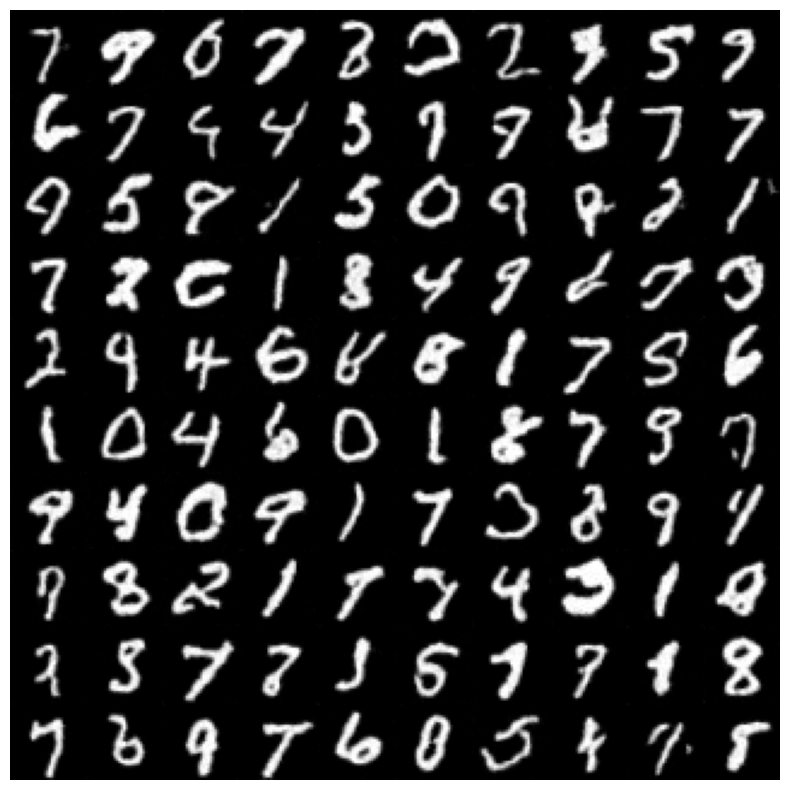

In [ ]:
nb_images = 100
samples = diffusion_model.sampling(n_samples=nb_images)

samples_grid = samples.reshape(10, 10, 1, 32, 32)

# Concatenate the images in the grid
samples_grid = samples_grid.permute(0, 3, 1, 4, 2).reshape(10 * 32, 10 * 32, 1)

# Display the grid
plt.figure(figsize=(10, 10))
plt.imshow(samples_grid.squeeze(-1).clip(0, 1).data.cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

100%|██████████| 1000/1000 [00:35<00:00, 27.84it/s]


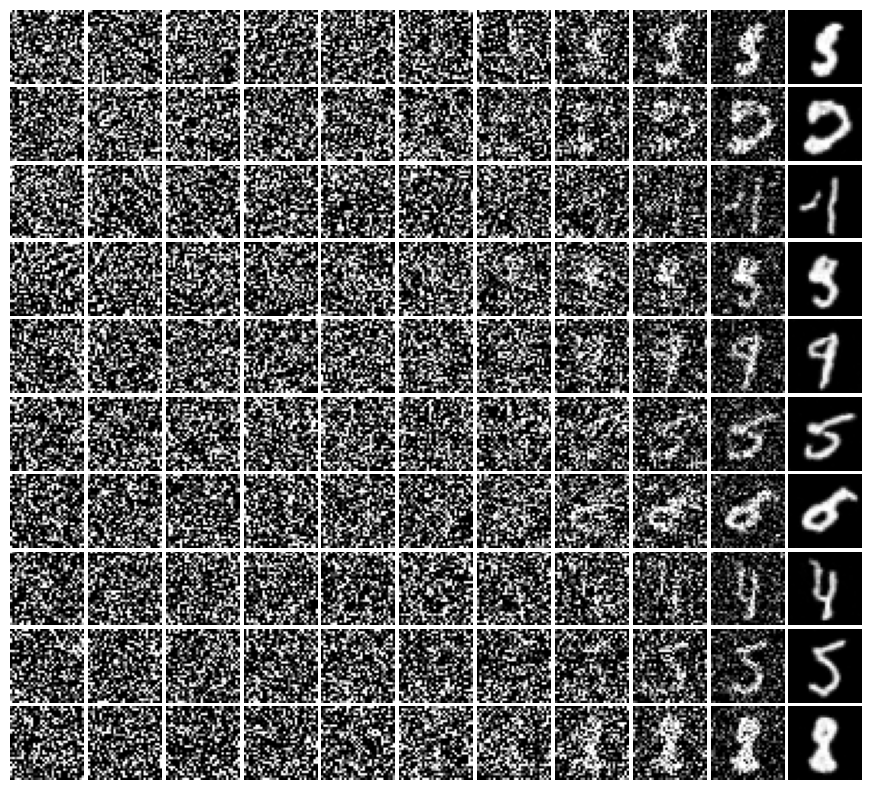

In [ ]:
timelapse_samples = diffusion_model.sampling_timelapse(interval=100)

fig, axes = plt.subplots(10, 11, figsize=(11, 10))
for i in range(10):
    for j in range(11):
        img = timelapse_samples[j][i].squeeze(0).clip(0, 1).numpy()
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [ ]:
torch.save(model.state_dict(), 'unet_model_weights.pth')

In [ ]:
model = UNet()
model.load_state_dict(torch.load('unet_model_weights.pth'))
diffusion_model = DiffusionModel(1000, model, device)
model.eval() # Set the model to evaluation mode

UNet(
  (linear1): Linear(in_features=128, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0-1): 2 x ResNetBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dense): Linear(in_features=512, out_features=128, bias=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (nonlinearity): SiLU()
    )
    (2): Downsample(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3): ResNetBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dense): Linear(in_features=512, out_features=256, bias=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (nin): Nin()
      (nonlinearity): SiLU()
    )
    (4): AttentionBlock(
      (Q): Nin()
     